# Practise Pandas and clean merge data

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/merge_16.csv")
# print(file.columns.tolist())
# print(file["Extension (P)"][4])
# file.dtypes()
# print(file.head())
# für array nur von den Daten: file.values()
# file.sort_index(axis = 1, ascending = True) //um überschriften zu sortieren zb nach alphabet
#sorted = file.sort_values(by = "Extension (P)")
# print(a["Extension (P)"])
# für statistics also mean std usw: file.describe()
# print(file[0:3])
# mehrere spalten auswählen: file.loc[:, ['A','B']]


# a= df['Extension (P)'].values
# print(a)
# print(np.any(np.isnan(a)))

df = df.sort_values(by = "Backspin Rate (P)")
print(df["Backspin Rate (P)"])
for i in range(2289,2269, -1):
    df = df.drop(df.index[[i]])
print(df["Backspin Rate (P)"])

In [ ]:
koord = df.iloc[:,df.columns.get_loc("0"):df.columns.get_loc("159")]

"""clean data by deleting nan columns"""
for col in df.columns.tolist():
    if (type(df[col][0]) is not np.float64 and type(df[col][0]) is not np.int64) or np.any(np.isnan(df[col].values)):
        df.drop(col, axis=1, inplace=True)

for col in koord.columns.tolist():
    df[col]=koord[col]

print(df.columns.tolist())

In [ ]:
df.to_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/merge_clean.csv")

In [ ]:
cl = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/merge_clean.csv")
#print(cl.columns.tolist())
#print(cl["0"])


In [ ]:
cf = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/cf_data.csv")
sv = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/sv_data.csv")

# Get coordinate values and pitch type labels seperately

In [ ]:
coordinates = cf.iloc[:,cf.columns.get_loc("0"):cf.columns.get_loc("166")]

In [ ]:
unique  = np.unique(cf["Pitch Type"].values)

In [ ]:
def oneHot(dataframe, column):
    unique  = np.unique(dataframe[column].values)
    l = len(dataframe.index)
    loc = dataframe.columns.get_loc(column)
    labels = np.zeros((l, 12))
    for i in range(l):
        #print(cf.iloc[i,loc])
        pitch = dataframe.iloc[i,loc]
        ind = unique.tolist().index(pitch)
        labels[i, ind] = 1
    return labels, unique

labels, _ = oneHot(cf, "Pitch Type")

In [ ]:
data_array = coordinates.values

# Change pandas dataframe to np.array
(Problem: missing values in den Koordinaten)

In [ ]:
M, N = data_array.shape
data = np.zeros((M,N,18,2))

for i in range(M):
    for j in range(N):
        if not pd.isnull(data_array[i,j]):
            data[i,j]=np.array(eval(data_array[i,j]))

#print(data)

In [ ]:
missing = pd.isnull(data_array)
print("Ratio missing: ", np.count_nonzero(missing)/(M*N))

# Tensorflow conv net

In [ ]:
train_x = data[:13000,:]
test_x = data[13000:, :]
train_t= labels[:13000,:]
test_t = labels[13000:, :]

print(len(train_x))
print(len(test_x))

In [ ]:
import tensorflow as tf

x = tf.placeholder(tf.float32, (None, N, 18, 2), name = "input")
x_ = tf.reshape(x, (-1, N, 36 ,1))
y = tf.placeholder(tf.float32, (None, len(labels[0])))

net = tf.layers.conv2d(x_, filters=16, kernel_size=5, strides=2, activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=16, kernel_size=3, strides=1, activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=1, activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=1, kernel_size=1)
shapes = net.get_shape().as_list()
ff = tf.reshape(net, (-1, shapes[1]*shapes[2]))
ff = tf.layers.dense(ff, 128, activation = tf.nn.relu)
ff = tf.layers.dense(ff, len(labels[0]), activation = tf.nn.sigmoid)

loss = tf.reduce_mean(tf.square(y-ff))
optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [ ]:
def batches(x, y, batchsize=32):
    permute = np.random.permutation(len(x))
    for i in range(0, len(x)-batchsize, batchsize):
        indices = permute[i:i+batchsize]
        yield x[indices], y[indices]
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Run session for 2000 epochs
for epoch in range(2000 + 1):
    for batch_x, batch_t in batches(train_x, train_t, 32):
        sess.run(optimizer, {x: batch_x, y: batch_t})
    print(epoch, sess.run(loss, {x: test_x, y: test_t}))
    

In [ ]:
print(sess.run(loss, {x: test_x, y: test_t}))

# one hot encoding

In [ ]:
def decode_one_hot(results):
    """takes the maximum value and gets the corresponding pitch type
    input: array of size trials * pitchTypesNr
    returns: array of size trials containing the pitch type as a string
    """
    unique  = np.unique(cf["Pitch Type"].values)
    p = []
    for pitch, i in enumerate(results):
        ind = np.argmax(pitch)
        p.append(unique[ind])
    return p

testing = sess.run(ff, {x: test_x, y: test_t})
pitches = decode_one_hot(testing)
label_pitches = (cf["Pitch Type"].values)[13000:]

# evaluate error rate
right = 0
wrong = 0
for i in range(len(pitches)):
    if pitches[i]==label_pitches[i]:
        right+=1
    else:
        wrong+=1
print(right/(right+wrong))

In [ ]:
def oneHot(dataframe, column):
    unique  = np.unique(dataframe[column].values)
    l = len(dataframe.index)
    loc = dataframe.columns.get_loc(column)
    labels = np.zeros((l, 12))
    for i in range(l):
        #print(cf.iloc[i,loc])
        pitch = dataframe.iloc[i,loc]
        ind = unique.tolist().index(pitch)
        labels[i, ind] = 1
    return labels, unique

def decode_one_hot(results, unique):
    """takes the maximum value and gets the corresponding pitch type
    input: array of size trials * pitchTypesNr
    returns: array of size trials containing the pitch type as a string
    """
    #unique  = np.unique(cf["Pitch Type"].values)
    p = []
    print(results)
    for i, pitch in enumerate(results):
        #print(pitch)
        ind = np.argmax(pitch)
        #print(ind)
        p.append(unique[ind])
    return p

labels, unique = oneHot(frame, "Pitch Type")

new = decode_one_hot(labels, unique)
print(np.sum(new==frame["Pitch Type"]))

# Only pitcher 

In [ ]:
df = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/cf_data.csv")
#df = df.sort_values(by = "Player") # Ball Picther or Strike outcome pitcher
# bis 8615 ball/pitcher
pitcher = df.loc[frame["Player"]=="Pitcher"]
pitcher.to_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/cf_only_pitcher.csv")

In [ ]:
frame = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/cf_only_pitcher.csv")
print(len(frame["Player"]))

In [ ]:
a = frame.loc[frame["Player"]=="Pitcher"]

In [ ]:
print(a.iloc[650, a.columns.get_loc("Player")])

In [ ]:
arr1 = (["hi", "ni", "gu"])
arr2 = (["hi", "nina", "gu"])
arr3 = np.asarray(arr1)==np.asarray(arr2)
print(arr3)
print(np.sum(arr3))

print(type(frame["Player"].values[6000:]))

In [ ]:
cf = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/cf_only_pitcher.csv")

print("csv eingelesen")
# COORDINATES
coordinates = cf.iloc[:,cf.columns.get_loc("0"):cf.columns.get_loc("166")]
data_array = coordinates.values
M, N = data_array.shape
data = np.zeros((M,N,18,2))

c=0
for i in range(M):
    for j in range(N):
        if not pd.isnull(data_array[i,j]):
            data[i,j]=np.array(eval(data_array[i,j]))
        else:
            c+=1

np.save("coord_array", data)

In [ ]:
SEP = 6000
EPOCHS = 30

print("imports")
cf = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/cf_only_pitcher.csv")

print("csv eingelesen")
# COORDINATES
"""
coordinates = cf.iloc[:,cf.columns.get_loc("0"):cf.columns.get_loc("166")]
data_array = coordinates.values
M, N = data_array.shape
data = np.zeros((M,N,18,2))

c=0
for i in range(M):
    for j in range(N):
        if not pd.isnull(data_array[i,j]):
            data[i,j]=np.array(eval(data_array[i,j]))
        else:
            c+=1
print("nan in daten:",c)
"""

data = np.load("coord_array.npy")
M,N, _,_ = data.shape

# LABELS
def oneHot(dataframe, column):
    unique  = np.unique(dataframe[column].values)
    l = len(dataframe.index)
    loc = dataframe.columns.get_loc(column)
    labels = np.zeros((l, 12))
    for i in range(l):
        #print(cf.iloc[i,loc])
        pitch = dataframe.iloc[i,loc]
        ind = unique.tolist().index(pitch)
        labels[i, ind] = 1
    return labels, unique

def decode_one_hot(results, unique):
    """takes the maximum value and gets the corresponding pitch type
    input: array of size trials * pitchTypesNr
    returns: array of size trials containing the pitch type as a string
    """
    #unique  = np.unique(cf["Pitch Type"].values)
    p = []
    for _, pitch in enumerate(results):
        ind = np.argmax(pitch)
        p.append(unique[ind])
    return p

labels, unique = oneHot(cf, "Pitch Type")
label_pitches = (cf["Pitch Type"].values)[SEP:]

# NET

np.save("labels", labels)
np.save("unique", unique)
np.save("label_pitches", label_pitches)


In [ ]:
df = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/merge_16.csv")
print(df.columns.tolist())

In [ ]:
df = df.loc[df["Player"] == "Pitcher"]
coordina = df.iloc[:, df.columns.get_loc("0"):df.columns.get_loc("159")]

In [ ]:
M, N = coordina.values.shape
SEP = int(M*0.9)
print("The training data will be up to %d and the test data from %d to %d"%(SEP, SEP, M))

In [ ]:
pointer = df.columns.get_loc("0")
columns = df.columns.tolist()
start = pointer
while(True):
    try:
        zahl = int(columns[pointer])
        pointer+=1
    except ValueError:
        break

coord = df.iloc[:, start:pointer]

# Standardizing and balancing

In [ ]:
import pandas as pd
import numpy as np
cf = pd.read_csv("merge_16.csv")
cf = cf[cf["Player"]=="Pitcher"]

In [ ]:
import scipy as sp
import scipy.stats

print(np.unique(cf["Pitch Type"].values))

types = cf["Pitch Type"].values
note_frequency = sp.stats.itemfreq(types)
print(note_frequency)
smaller_20 = (note_frequency[np.where(note_frequency[:,1]<30)])[:,0].flatten()

for typ in smaller_20:
    cf = cf.drop(cf[cf["Pitch Type"]==typ].index)


print(np.unique(cf["Pitch Type"].values))
#cf = cf.drop(cf[cf["Pitch Type"]=='Fastball (Split-finger)' or cf["Pitch Type"]=="Unknown Pitch Type"].index)

In [ ]:
arr = np.load("coord_array.npy")
print(np.any(np.isnan(arr)))
means = np.mean(arr, axis = 1)
std = np.std(arr, axis = 1)
res = np.asarray([(arr[:,i]-means)/(std+0.0001) for i in range(len(arr[0]))])
new = np.swapaxes(res, 0,1)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

data = compute_class_weight("auto", np.unique(cf["Pitch Type"].values),cf["Pitch Type"].values )

In [ ]:
labels_string= cf["Pitch Type"].values
unique =np.unique(labels_string)
#print(np.unique(pitches))
#print(np.sum(data))
nr_classes=len(unique)
ex_per_class = 4

"""liste=np.zeros((7,4))
for i, types in enumerate(np.unique(pitches)):
    liste[i] = (np.random.choice(np.where(pitches==types)[0], 4))
print(liste)
"""
index_liste = []
for pitches in unique:
    index_liste.append(np.where(labels_string==pitches))
    
def balanced_batches(y):   
    for j in range(5):
        liste=np.zeros((nr_classes, ex_per_class))
        for i in range(nr_classes):
            liste[i] = np.random.choice(index_liste[i][0], ex_per_class)
        #print(liste.flatten().astype(int))
        yield y[liste.flatten().astype(int)]

In [ ]:
for batch_x in balanced_batches(labels_string):
    print(batch_x)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
#from sklearn.preprocessing import StandardScaler
from data_preprocess import Preprocessor

def decode_one_hot(results, unique):
    """takes the maximum value and gets the corresponding pitch type
    input: array of size trials * pitchTypesNr
    returns: array of size trials containing the pitch type as a string
    """
    #unique  = np.unique(cf["Pitch Type"].values)
    p = []
    for _, pitch in enumerate(results):
        ind = np.argmax(pitch)
        if pitch[ind]>0.5:
            p.append(unique[ind])
        else:
            p.append("Too small")
    return p

leaky_relu = lambda x: tf.maximum(0.2*x, x)


ex_per_class = 4
EPOCHS = 10
PATH = "/Users/ninawiedemann/Desktop/UNI/Praktikum/sv_data.csv"
LABELS = "Pitch Type"
act = leaky_relu
CUT_OFF_Classes = 60

prepro = Preprocessor(PATH, CUT_OFF_Classes)
data = np.load("coord_sv.npy") #prepro.get_coord_arr("coord_sv.npy")

M,N,nr_joints,_ = data.shape
SEP = int(M*0.9)

labels, unique = prepro.get_labels_onehot(LABELS)
labels_string = prepro.get_labels(LABELS)
#labels_test = decode_one_hot(labels[SEP:, :], unique)

nr_classes = len(np.unique(labels_string))
BATCHSIZE = nr_classes*ex_per_class
print("nr classes", nr_classes, "Batchsize", BATCHSIZE)

# NET

ind = np.random.permutation(len(data))
train_ind = ind[:SEP]
test_ind = ind[SEP:]

train_x = data[train_ind]
test_x = data[test_ind]
train_t= labels[train_ind]
test_t = labels[test_ind]
labels_string_train = labels_string[train_ind]
labels_string_test = labels_string[test_ind]

"""
DATA TESTING:
indiuh = np.where(ind==2000)
print("Labels nach preprocc von 2000", labels_string[2000])
print("new Index of 2000", indiuh, "test ob where funkt: ", ind[indiuh])
print("train coord of 2000 u 140", train_x[indiuh, 140])
print("labels_string von 2000", labels_string_train[indiuh])
print("one hot von 2000", train_t[indiuh])
"""

index_liste = []
for pitches in unique:
    index_liste.append(np.where(labels_string_train==pitches))

len_test = len(test_x)
len_train = len(train_x)
print("Test set size: ", len_test, " train set size: ", len_train)
print("Shapes of train_x", train_x.shape, "shape of test_x", test_x.shape)

# normal conv net

In [ ]:
x = tf.placeholder(tf.float32, (None, N, nr_joints, 2), name = "input")
x_ = tf.reshape(x, (-1, N, nr_joints*2))
y = tf.placeholder(tf.float32, (None, len(labels[0])))

net = tf.layers.conv1d(x_, filters=256, kernel_size=5, strides=2, activation=act)
net = tf.layers.conv1d(net, filters=256, kernel_size=3, strides=1, activation=act)
net = tf.layers.conv1d(net, filters=128, kernel_size=3, strides=1, activation=act)
net = tf.layers.conv1d(net, filters=1, kernel_size=1, activation = act)
shapes = net.get_shape().as_list()
ff = tf.reshape(net, (-1, shapes[1]*shapes[2]))
ff = tf.layers.dense(ff, 1024, activation = act)
ff = tf.layers.dense(ff, 128, activation = act)
logits = tf.layers.dense(ff, len(labels[0]), activation = None)
out = tf.nn.softmax(logits)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)) # tf.reduce_mean(tf.square(y-ff))
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

# basic lstm

In [ ]:
import tensorflow as tf
from tensorflow.contrib import rnn

learning_rate = 0.001
training_iters = 100000
batch_size = BATCHSIZE
display_step = 10

tf.reset_default_graph()

# Network Parameters
n_input = nr_joints*2 # MNIST data input (img shape: 28*28)
n_steps = N # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 12 # MNIST total classes (0-9 digits)

# tf Graph input
x_ = tf.placeholder("float", [None, n_steps, nr_joints, 2])
x = tf.reshape(x_, (-1, N, nr_joints*2))
y = tf.placeholder("float", [None, n_classes])

"""# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}"""


def RNN(x):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)
    
    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    """with tf.variable_scope("myrnn") as scope:
        for i in range(n_steps-1):
            if i > 0:
                scope.reuse_variables()
            output, state = lstm_cell(x[i], state)"""

    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.layers.dense(outputs[-1], n_classes)   #tf.matmul(outputs[-1], weights['out']) + biases['out']

out_logits = RNN(x)
out = tf.nn.softmax(out_logits)

# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out_logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# multi layer lstm

In [ ]:
import tensorflow as tf
from tensorflow.contrib import rnn

learning_rate = 0.001
training_iters = 100000
batch_size = BATCHSIZE
display_step = 10
nr_layers = 4

tf.reset_default_graph()

# Network Parameters
n_input = nr_joints*2 # MNIST data input (img shape: 28*28)
n_steps = N # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 12 # MNIST total classes (0-9 digits)

# tf Graph input
x_ = tf.placeholder("float", [None, n_steps, nr_joints, 2])
x = tf.reshape(x_, (-1, N, nr_joints*2))
y = tf.placeholder("float", [None, n_classes])

"""# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}"""


def RNN(x):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)
    
    # Define a lstm cell with tensorflow
    #lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    
    def lstm_cell():
          return rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    
    stacked_lstm = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(nr_layers)])


    # Get lstm cell output
    """with tf.variable_scope("myrnn") as scope:
        for i in range(n_steps-1):
            if i > 0:
                scope.reuse_variables()
            output, state = lstm_cell(x[i], state)"""

    outputs, states = rnn.static_rnn(stacked_lstm, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.layers.dense(outputs[-1], n_classes)   #tf.matmul(outputs[-1], weights['out']) + biases['out']

out_logits = RNN(x)
out = tf.nn.softmax(out_logits)

# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out_logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# training

In [ ]:
def batches(x, y, batchsize=32):
    permute = np.random.permutation(len(x))
    for i in range(0, len(x)-batchsize, batchsize):
        indices = permute[i:i+batchsize]
        yield x[indices], y[indices]

def balanced_batches(x, y, batchsize=32):
    for j in range(200):
        liste=np.zeros((nr_classes, ex_per_class))
        for i in range(nr_classes):
            # print(j, i, np.random.choice(index_liste[i][0], ex_per_class))
            liste[i] = np.random.choice(index_liste[i][0], ex_per_class, replace=False)
        liste = liste.flatten().astype(int)
        yield x[liste], y[liste]

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Run session for EPOCH epochs
for epoch in range(EPOCHS + 1):
    for batch_x, batch_t in balanced_batches(train_x, train_t, BATCHSIZE):
        sess.run(optimizer, {x_: batch_x, y: batch_t})
    # print("Loss test: ", sess.run(loss, {x: test_x, y: test_t}))
    #print("Loss train: ", sess.run(loss, {x: train_x, y: train_t}))

    #Test Accuracy
    loss_test, out_test = sess.run([loss,out], {x_: test_x, y: test_t})
    print("Loss test", loss_test)
    pitches_test = decode_one_hot(out_test, unique)
    print("Accuracy test: ", np.sum(np.asarray(labels_string_test)==pitches_test)/len_test)
    
    #Train Accuracy
    out_train = sess.run(out, {x_: train_x, y: train_t})
    pitches_train = decode_one_hot(out_train, unique)
    print("Accuracy train: ", np.sum(np.asarray(labels_string_train)==pitches_train)/SEP)

print(pitches_test)

# cut file to stretch and pitch type

In [ ]:
import numpy as np

out_list = ["ine", "ine", "bdeu", "hdba", "nina", "nina"]
ground_truth_list = ["ine","ine", "bdeu", "ine", "nina", "halo"]

out = np.array(out_list)
ground_truth = np.array(ground_truth_list)

same = out[np.where(out==ground_truth)[0]]

right_frequency = sp.stats.itemfreq(same)
total_frequency = sp.stats.itemfreq(ground_truth)
right_dict = dict(zip(right_frequency[:,0], right_frequency[:,1]))
total_dict = dict(zip(total_frequency[:,0], total_frequency[:,1]))

acc= right_dict
for types in right_dict.keys():
    acc[types] = (int(right_dict[types])/float(total_dict[types]))


print(acc)

In [ ]:
#cf = np.load("coord_array.npy")
#sv = np.load("coord_sv.npy")
#print(cf.shape, sv.shape)

cf = pd.read_csv("cf_data.csv")
sv = pd.read_csv("sv_data.csv")


In [ ]:
cf = cf[cf["Player"]=="Pitcher"]
sv = sv[sv["Player"]=="Pitcher"]
cf_plays = cf['play_id'].values
print(sv[sv["play_id"]==cf_plays[0]].index)

In [ ]:
print(cf_plays)

In [ ]:
print(sv["play_id"].values)

In [ ]:
common_ids = []
sv_plays = sv["play_id"].values
for i, ids in enumerate(cf_plays):
    if ids in sv_plays:
        common_ids.append(ids)
        

In [ ]:
print(len(common_ids))
print(len(sv_plays))
print(len(cf_plays))

In [ ]:
print(cf["play_id"].values[0])
new = cf[cf["play_id"] in sv["play_id"].values]
print((np.array(sv_plays)==np.array(cf_plays)))
print(np.where(np.array(sv_plays)==np.array(cf_plays)))

In [ ]:
cf = pd.read_csv("cf_data.csv")
sv = pd.read_csv("sv_data.csv")


cf = cf[cf["Player"]=="Pitcher"]
sv = sv[sv["Player"]=="Pitcher"]


In [ ]:
pitcher = cf["Pitcher"].values.astype(int)
statistic = sp.stats.itemfreq(pitcher) #.sort(axis = 0)

number = np.array(frequ[:,1])

for i in range(5):
    maxi = np.argmax(number)
    a = frequ[maxi]
    number[maxi]=0
    print(a)

In [ ]:
split = cf[cf["Runner on 1st"]!=None]
print(split)

In [ ]:
import pandas as pd
import numpy as np

from data_preprocess import Preprocessor

#pre_cf = Preprocessor("cf_data.csv",60)
#new_data = pre_cf.concat_with_second("sv_data.csv")
#print(new_data)

PATH = "cf_data.csv"
LABELS = "Pitch Type"

prepro = Preprocessor(PATH)
players = prepro.get_list_with_most("Pitcher")
print(players)
#

In [ ]:
cf = pd.read_csv("cf_data.csv")


In [ ]:
print(cf.columns.tolist())

# histogram of 5 players with most pitches

In [ ]:
from data_preprocess import Preprocessor
prepro = Preprocessor("cf_data.csv")
players, _ = prepro.get_list_with_most("Pitcher")
#print(players[2])
pitchi = []
for i in range(5):
    prepro = Preprocessor("cf_data.csv")
    prepro.cut_file_to_pitcher(players[i])
    _, stat = prepro.get_list_with_most("Pitch Type")
    pitchi.append(stat)
print(pitchi)

In [19]:
for i in range(5):
    print(players[i], ": ", np.sum(pitchi[i][:, 1]))

527054.0 :  463
285079.0 :  435
592314.0 :  423
448802.0 :  325
656794.0 :  257


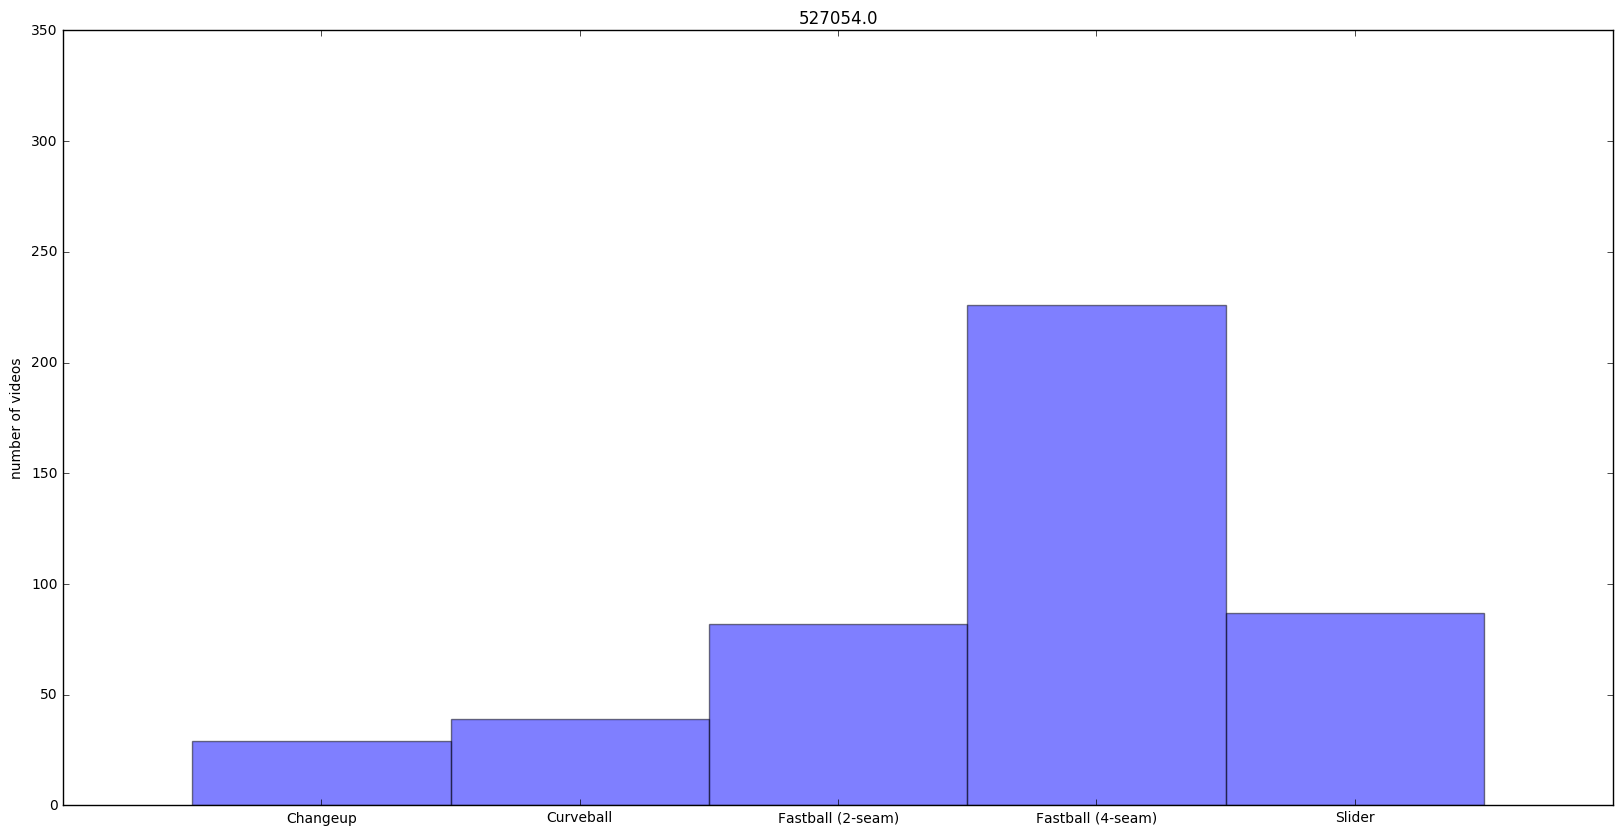

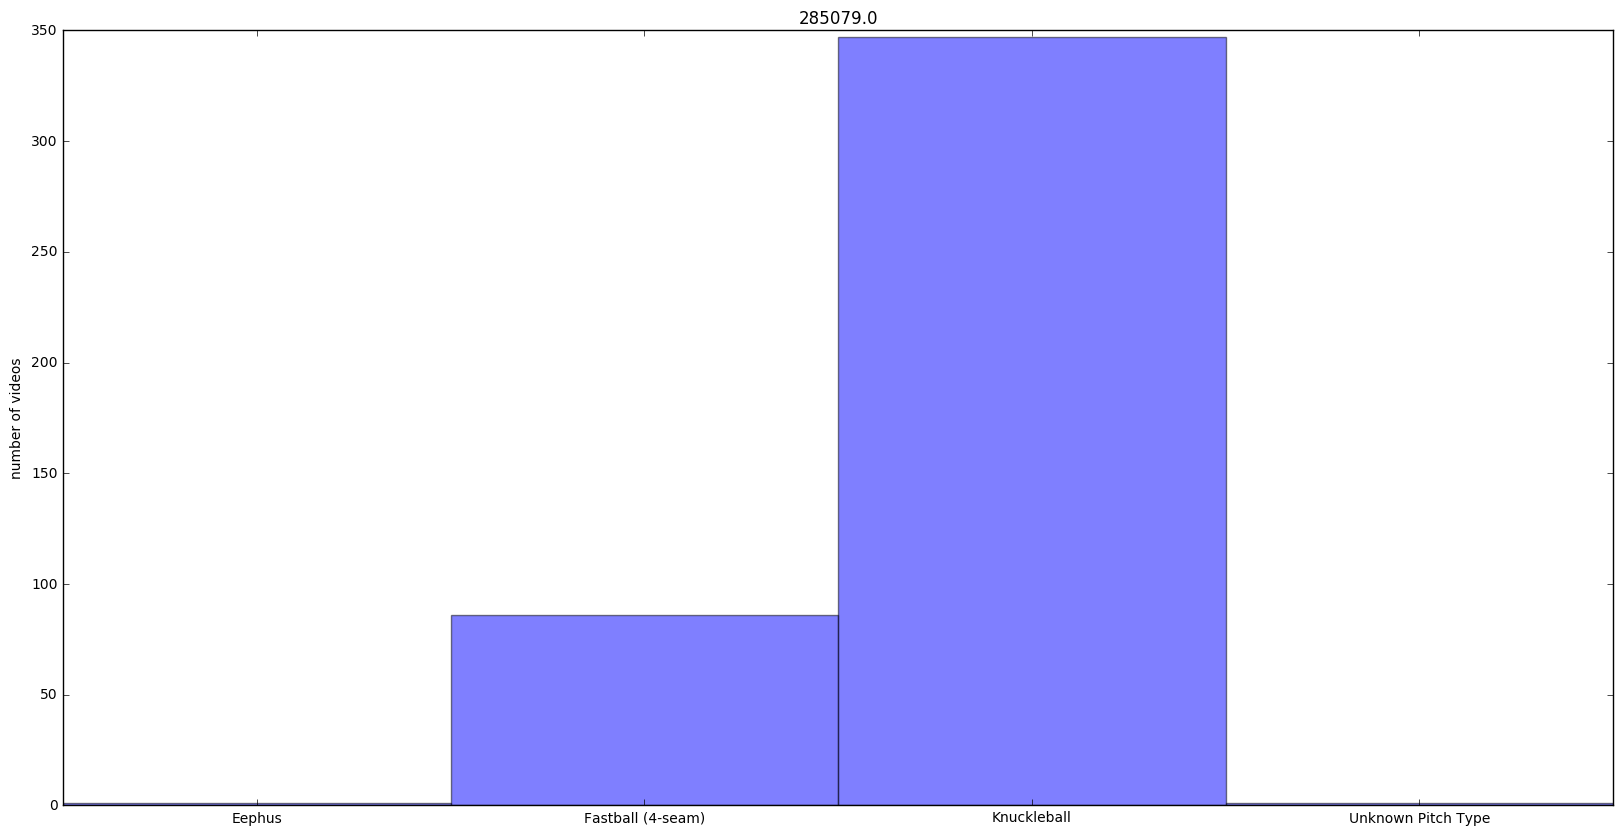

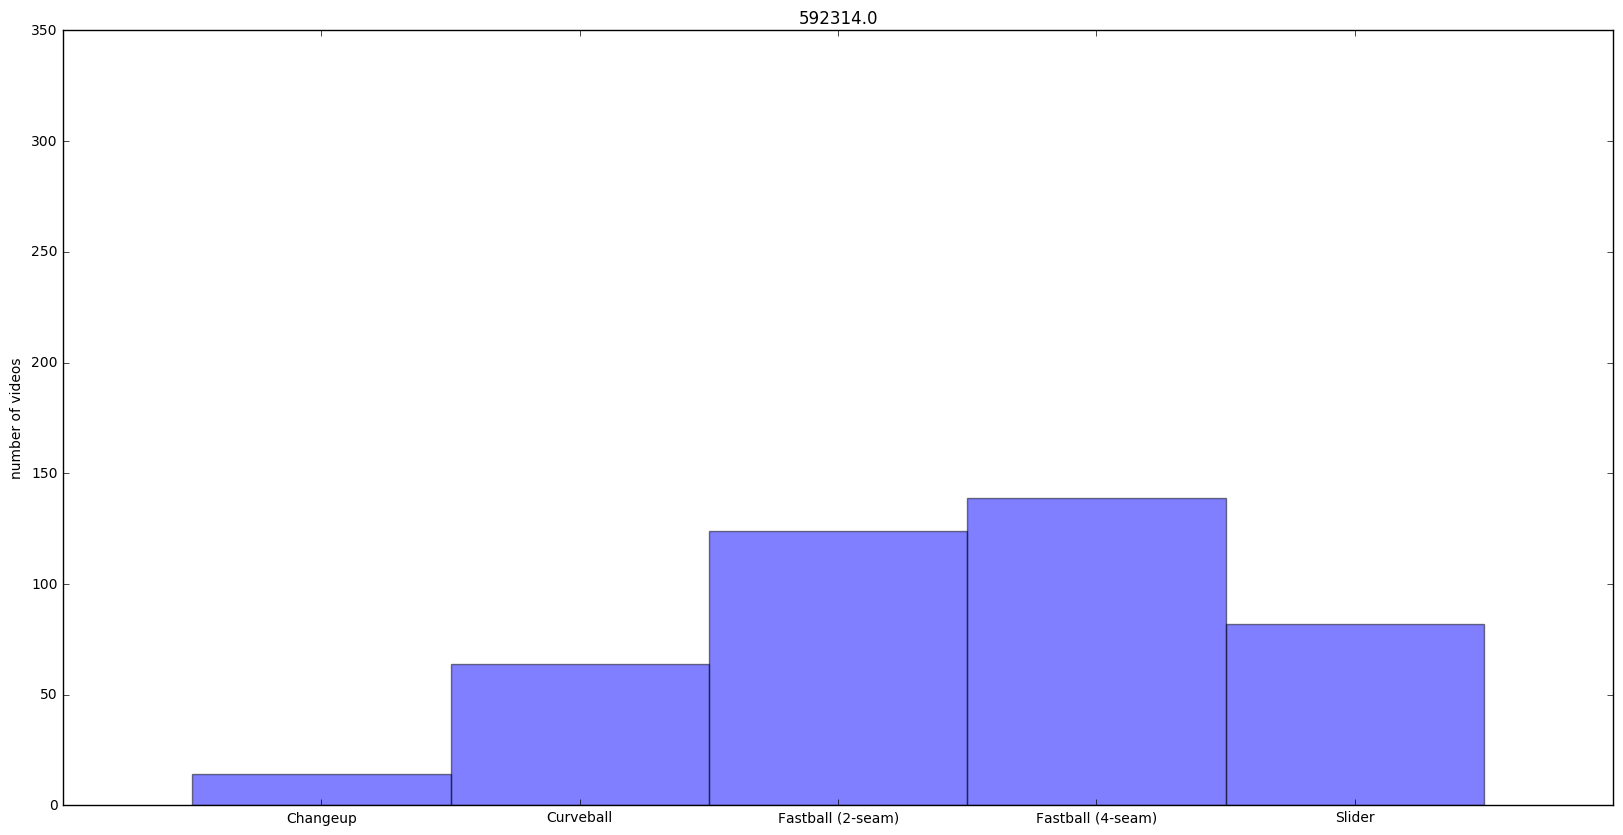

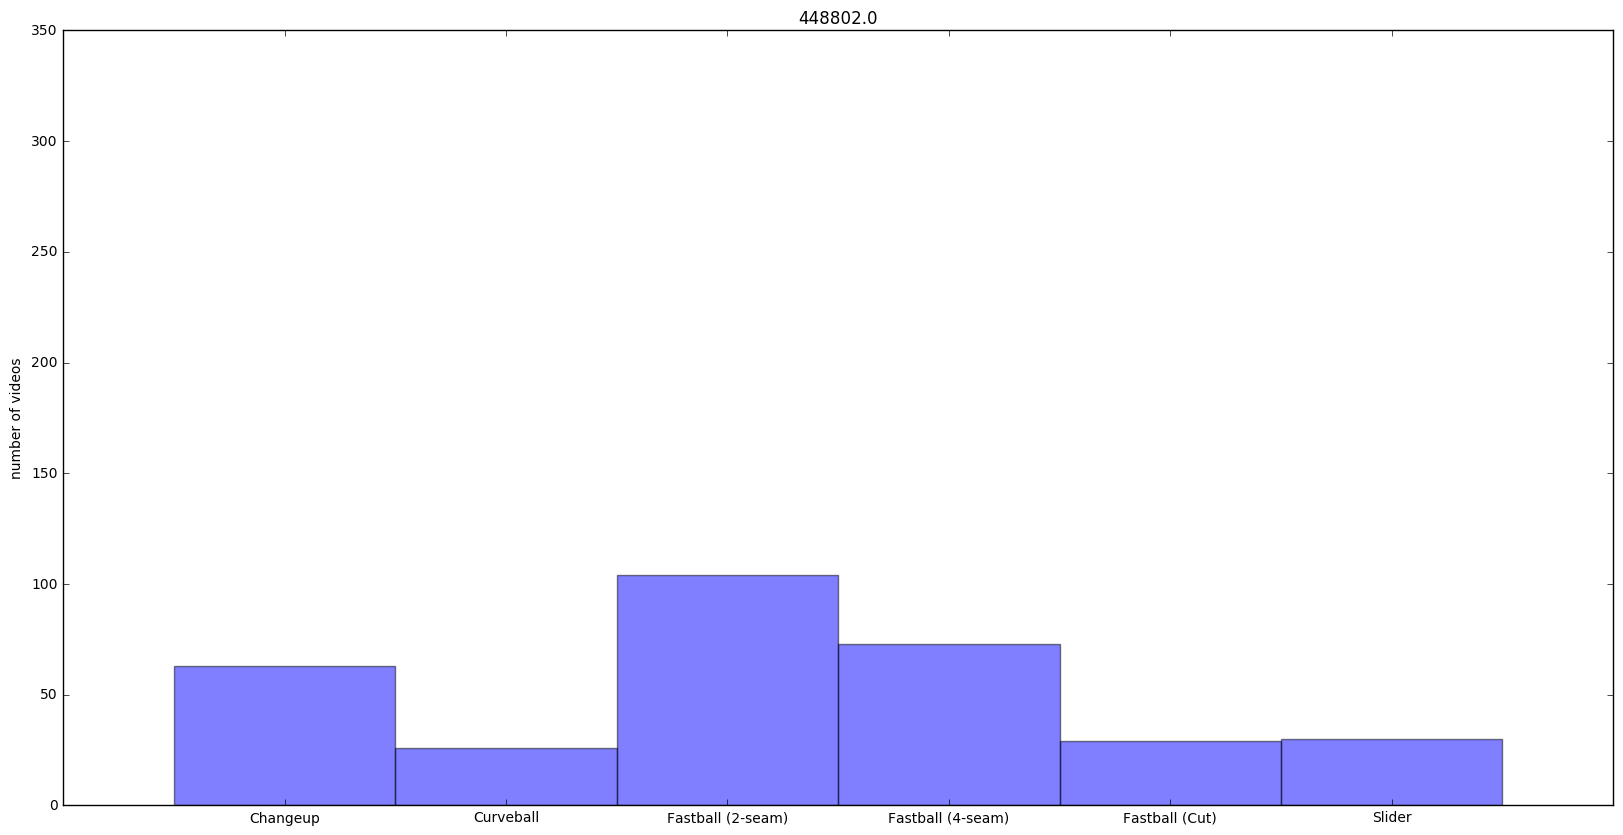

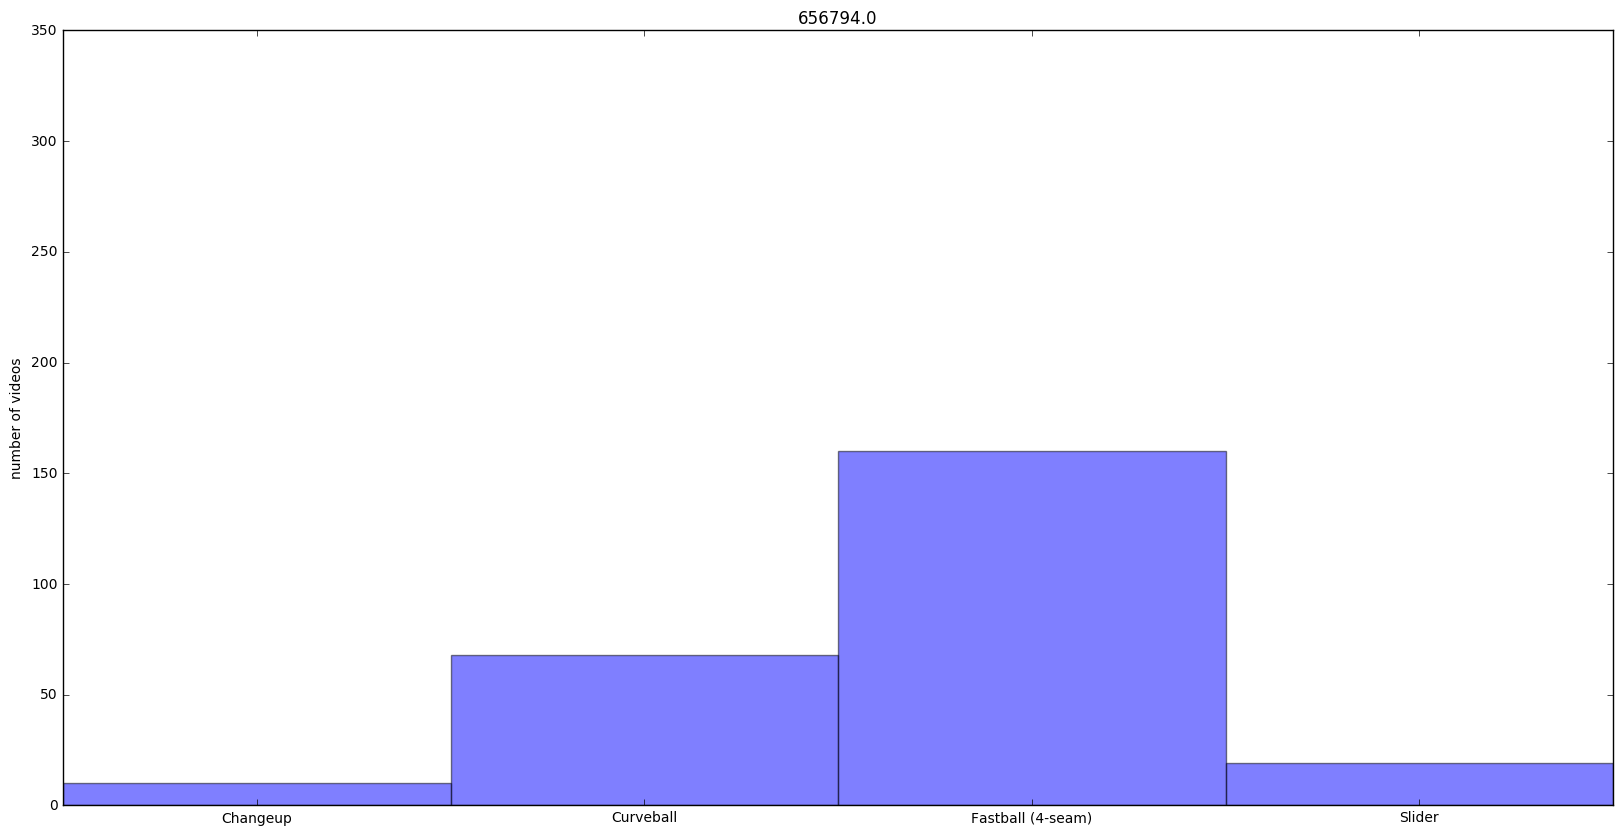

In [18]:
#data=np.random.random((4,10))
import matplotlib.pylab as plt
import numpy as np
#xaxes = ['t1','t2','t3','t4'] 
#yaxes = ['y1','y2','y3','y4']
titles = players
for i in range(5):
    
    plt.figure(figsize=(20,10))
    plt.ylim([0,350])
    y_pos = range(len(pitchi[i]))
    plt.bar(y_pos, pitchi[i][:,1], align='center', alpha=0.5, width = 1)
    #plt.ylim([0,350])
    plt.xticks(y_pos, pitchi[i][:,0])
    plt.ylabel('number of videos')
    plt.title(titles[i])
    plt.show()

In [ ]:
import shutil
shutil.rmtree("logs")

# Try to plot coordinates

In [31]:
import pandas as pd
import numpy as np

from data_preprocess import Preprocessor
prepro = Preprocessor("cf_data.csv")

/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (253,254,255,256,257,258,259,289) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


csv eingelesen with length  13150
Only Pitcher rows


In [33]:
players, _ = prepro.get_list_with_most("Pitcher")
prepro.select_movement("Stretch")
prepro.cut_file_to_pitcher(players[2]) 

Selected all rows with Pitching position  Stretch


In [35]:
df = prepro.cf
pitchi, _ = prepro.get_list_with_most("Pitch Type")
df = df[df["Pitch Type"]==pitchi[0]]

In [36]:
prepro.cf = df

In [37]:
data = prepro.get_coord_arr()

percent of missing values: 0.012384322264561785


In [ ]:
print(data.shape)
print(data)

In [47]:
#print(data[10])

(88, 167, 18, 2)


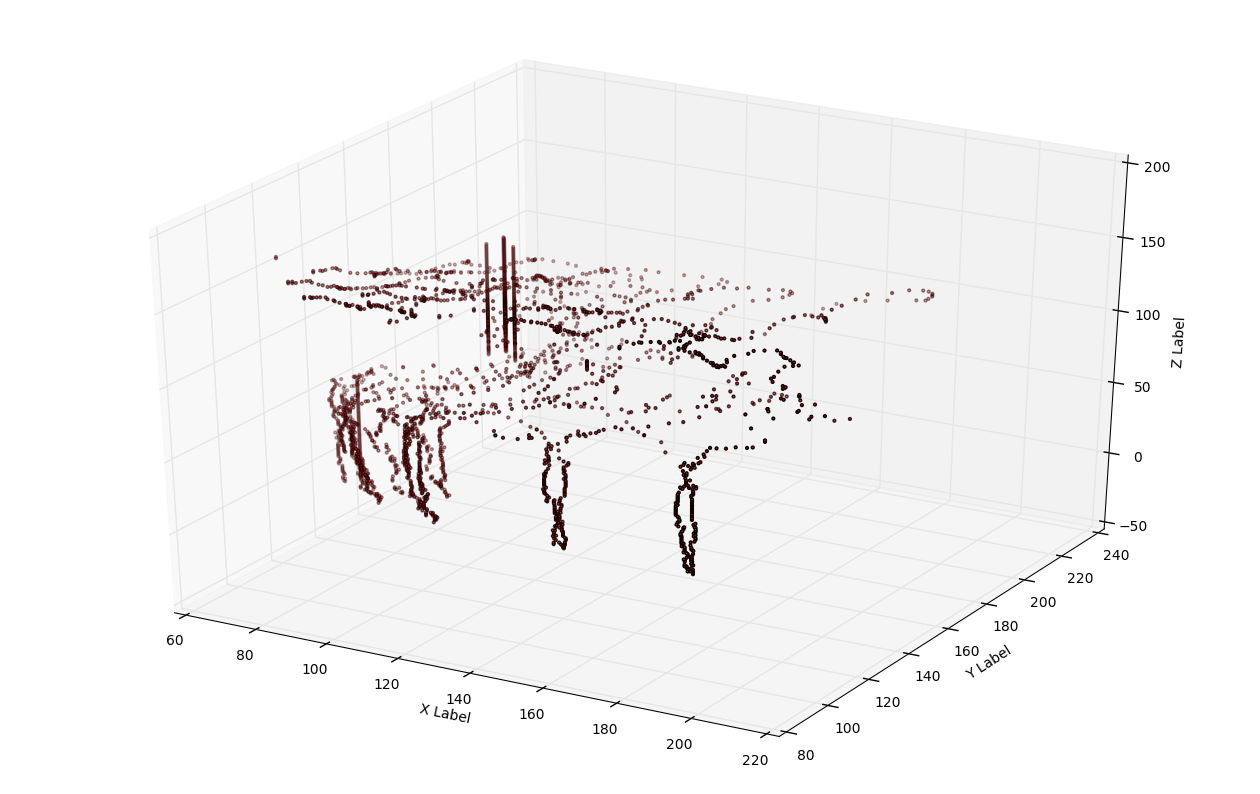

In [46]:
print(data.shape)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')

#z=range(167)
for i in range(167):
    ax.scatter(data[10, i, :16, 0], data[10, i, :16, 1], i, c= 'red', s=4)


#for i in range(18):
#    ax.scatter(data[10, :, i, 0], data[10, i, :, 1], z, c= 'red', s=1)
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()
#Axes3D.scatter(mean_data[0], mean_data[1], mean_data[2])

In [29]:
print(max(prepro.cf['first_movement_frame_index'].values))


82.0


In [26]:
import pandas as pd
cf = pd.read_csv("cf_data.csv")

/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (253,254,255,256,257,258,259,289) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Ergebnisse

Best model for one player (here: the one with most trials) and all his pitch types (Stretch&windup mixed):

Convolutional NN with 4 conv layers and 3 fully connected feed forward layers, using regularization (L2 loss for weights and Dropout)

Frames aligned by first_movement_frame, head coordinates removed (only first 12)

nr classes 5 Batchsize 20 trained for 40 epochs, 100 balanced batches per epoch

classes:  ['Changeup', 'Curveball', 'Fastball (2-seam)', 'Fastball (4-seam)', 'Slider']

data shape: (463, 92, 12, 2) label_shape (463, 5) (463,)

Test set size:  47  train set size:  416

Shapes of train_x (416, 92, 12, 2) shape of test_x (47, 92, 12, 2)

# shorter version of conv net

all with alignment and concatenated data

conv_short version,      mit max_pooling, with conv-batch_norm-dropout architecture
    
player0: 53% (5 classes), 46,                  35

player1: 80% (2 classes), 85,                  70

player2: 27% (6 classes), 21,                  35

player3: 45% (5 classes), 23,                  36

player4: 35% (4 classes), 52,                  46

Same but only one pitchtype:

and concat data and alignment with conv-batch_norm-dropout architecture

player0: 62

player1: 77

player2: 75

player3: 59

player4: 84

In [ ]:
"""
Trained on concatenated data from cf and sv (4 coordinates) on only Windup 53%, only Stretch 54%, all 50%
(without alignment and without regularization loss)
"""
def best_in_cluster_concat53(self, x, nr_classes, training, rate_dropout=0.6, act=tf.nn.relu):
        shape = x.get_shape().as_list()
        x_ = tf.reshape(x, (-1, shape[1], shape[2]*shape[3]))
        net = tf.layers.conv1d(x_, filters=256, kernel_size=5, strides=2, activation=act, name="conv1")
        tf.summary.histogram("conv_1_layer", net)
        # net = tf.layers.dropout(net, rate=rate_dropout, training=training)
        net = tf.layers.conv1d(net, filters=128, kernel_size=3, activation = act, name="conv4")
        shapes = net.get_shape().as_list()
        ff = tf.reshape(net, (-1, shapes[1]*shapes[2]))
        logits = tf.layers.dense(ff, nr_classes, activation = None, name = "ff3")
        out = tf.nn.softmax(logits)
        return out, logits
    
"""Trained on only one pitch type: about 75% with higher batchsize 78
"""

# Align pitches by "first_movement_frame_index"

In [63]:
release_frame = prepro.cf["first_movement_frame_index"].values

def align_frames(data, release_frame, fr_before, fr_after):
    """
    Takes the data and an array that indicates the frame number of the first movement
    cuts all data to fr_before the release_frame and fr_after the release frame
    returns an array of size data.shape except the second dimension is cut to length fr_before+fr_after
    """
    M, _, nr_joints, nr_coord = data.shape
    new = np.zeros((M, fr_after+fr_before, nr_joints, nr_coord))
    for i, row in enumerate(data):
        ind = release_frame[i]
        if pd.isnull(ind):
            ind = np.mean(release_frame[:i])
        start = int(ind-fr_before)
        end = int(ind+ fr_after)
        #print(start, end)
        new[i] = data[i, start:end, :,:]
    return new

# RNN/ LSTM
tf learn module to create a RNN 

In [49]:
import tflearn
def get_network_wide(frames, input_size, num_classes):
    """Create a one-layer LSTM"""
    net = tflearn.input_data(shape=[None, frames, input_size])
    net = tflearn.lstm(net, 256, dropout=0.2)
    net = tflearn.fully_connected(net, num_classes, activation='softmax')
    net = tflearn.regression(net, optimizer='adam',
                             loss='categorical_crossentropy', name='output1')
    return net
model = DNN(get_network_wide(N, nr_joints*nr_coordinates, nr_classes))
model.fit(X, Y)

In [88]:
print("first_movement_frame_index")
print(prepro.cf["first_movement_frame_index"].values[:50])

print("'pitch_frame_index'")
print(np.where(prepro.cf['pitch_frame_index'].values<0))

first_movement_frame_index
[ 35.  40.  43.  38.  73.  75.  45.  46.  45.  76.  73.  45.  70.  50.  45.
  40.  57.  44.  42.  45.  40.  63.  64.  45.  64.  64.  61.  69.  39.  46.
  43.  44.  43.  43.  44.  59.  47.  35.  40.  75.  75.  76.  40.  29.  54.
  41.  38.  73.  72.  75.]
'pitch_frame_index'
(array([ 135, 2223, 3906, 3913, 3930, 3938, 6273]),)


In [69]:
print(prepro.cf.columns.tolist())

['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '15